# Motor/Propeller Design



In [42]:
include("motorprop.jl");

In this analysis we simply sweep out the rotation speed, primarily to look at how the efficiency of the motor and prop compare.  This analysis only holds for one flight speed, and one voltage level (encoded here as a throttle setting, even through throttle may not be exactly linear with voltage depending on the ESC), and so we would need to rerun multiple times if we wanted to observe other flight speeds and throttle settings.  Nevertheless it is a convenient look at how well matched our motor and prop are at various conditions.

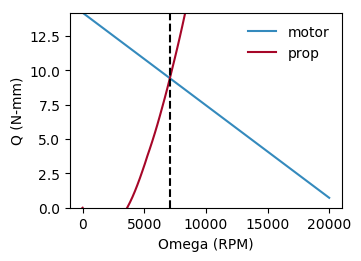

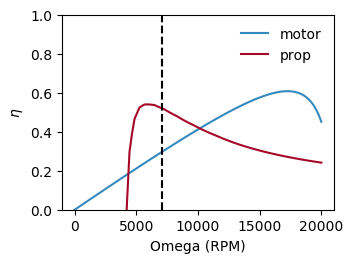

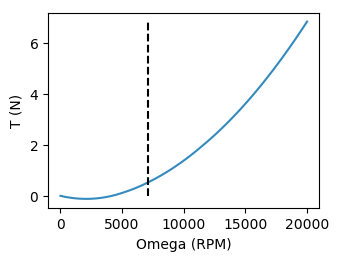

Total efficiency = 15.4%
Thrust = 0.521 N


In [39]:
# ---- motor, battery, and prop inputs -----

# --- motor ---
Kv = 3691.0  # (RPM/Volt)
i0 = 0.28  # no load current (Amps)
R = 1.04  # resistance (Ohms)
vbatt = 6.0  # battery voltage (Volts)

# --- prop ----
# propeller data with columns J, CT, CP, eta (same format and normalization as from the UIUC site)
pdata = [
0.191482  0.086401  0.052685  0.314019
0.240662  0.080442  0.050881  0.380485
0.283730  0.074008  0.048687  0.431285
0.331900  0.066418  0.046009  0.479131
0.380651  0.058242  0.042948  0.516207
0.428387  0.049274  0.039252  0.537762
0.483105  0.038575  0.034435  0.541189
0.523810  0.030842  0.030775  0.524940
0.572153  0.020118  0.025059  0.459336
0.619438  0.009292  0.018984  0.303199
0.673904 -0.002999  0.011728 -0.172340
]

D = 6.0 * 0.0254  # prop diamter (m)
rho = 1.225  # atmospheric density (kg/m^3)

# --- plot range ----
Omegamin = 1.0  # min RPM used for plotting range
Omegamax = 20000  # max RPM used for plotting range

# --- operating parameters (one voltage, one flight speed) ---
throttle = 1.0  # number between 0 and 1 - not exactly throttle depending on esc
                # more precisely it is applied voltage relative to battery capacity: v/vbatt

V = 7.0  # flight speed (m/s)
# ------------------------------------------


# run sweep
m = motordef(Kv, i0, R, vbatt)
p = propdef(pdata, D, rho)
etaT, Tp = motorpropsweep(m, p, Omegamin, Omegamax, throttle, V);

println("Total efficiency = ", round(etaT*100, 1), "%")
println("Thrust = ", round(Tp, 3), " N")

We could repeat this same analysis for many different flight speeds and see, for example, how the efficiency and thrust change with flight speed (for a fixed throttle setting).  However, that's probably not the most useful way to look at the data for our needs.  What we are most interested in is the steady level flight condition or when thrust = drag.  The thrust we get out of the simulation for a particular flight speed or throttle setting likely won't happen to match the thrust we need.  Instead, we will reformulate the analysis and add the additional constraint that we want T = D.  In other words, rather than using velocity and throttle setting as inputs, we will use velocity and thrust as inputs.  With a specified desired thrust, we can compute the requisite rotation speed that will provide that thrust and also get the associated propeller torque.  We can then compute the throttle (voltage) that equals the propeller torque (i.e., throttle setting is an indirect function of thrust desired).  Of course, the requisite thrust is equal to drag, and that changes with flight speed.  So in the end, our only input is velocity.  Everything else (thrust, and voltage) can be computed from that one input given our constraints.

We will assume a drag of the form
$$D = {C_D}_p q S_{ref} + \frac{L^2}{q \pi b^2 e} $$
where $L = W$.  This form assumes that the parasitic drag coefficient does not change appreciably with Reynolds number across the flight speeds, which is generally a good assumption for our range.  Keep in mind this gives minimum performance for level flight.  We actually need thrust to exceed drag in order to climb, but this is a reasonable place to start looking at our efficiencies.

Note that any results corresponding to a throttle > 1 are invalid.  In those cases it means that you would need more voltage that you can supply to produce the requisite thrust.

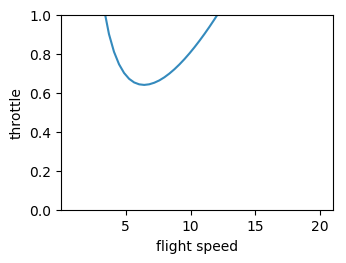

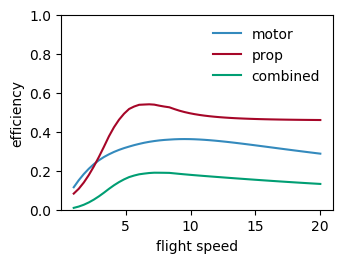

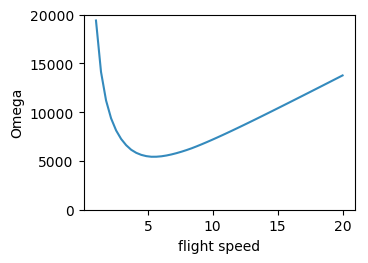

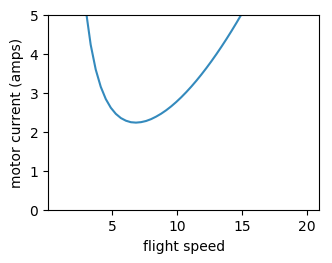

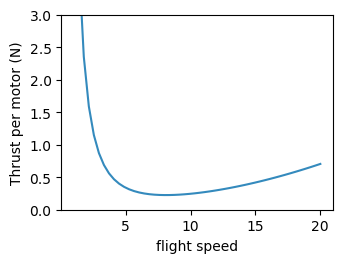

In [44]:
# ----------- other aircraft inputs ------------
CDp = 0.04  # parasitic drag coefficient
einv = 0.98  # inviscid span efficiency (NOT Oswald efficiency factor, that is computed internally)
Sref = 0.14  # reference area for CDp (m^2)
b = 1.1  # wing span (m)
nmotors = 2  # number of motors
mass = 500  # mass of airplane (grams)

# plotting parameters
Vmin = 1.0  # m/s
Vmax = 20.0  # m/s
Omegamax = 20000 # RPM (only used to cut off y-scale on last plot.  doesn't affect calculations at all.)
imax = 5.0  # Amp, just for ploting
Tmax = 3.0 # N, just for plotting 
# -----------------------

ac = acdef(CDp, einv, Sref, b, nmotors, mass)
steadylevelsweep(m, p, ac, Vmin, Vmax, Omegamax, imax, Tmax);